In [1]:
import numpy as np
import tensorflow as tf
import cv2
import os
import requests
import urllib
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D, MaxPool2D, Flatten, Dense, BatchNormalization, SeparableConv2D, Dropout, Activation

/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.24.3) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/Users/pengjunming/Desktop/Anaconda/anaconda3/envs/myenv/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data

We'll be using the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html), which contains some natural images tagged in 10 different categories (e.g. cars, dogs, birds etc.)

In [2]:
num_classes = 10 # number of classes in the data
img_rows, img_cols, img_channels = 32, 32, 3 # input image dimensions
input_shape = (img_rows, img_cols, img_channels)

# Load and convert data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Convert class vectors to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, img_channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, img_channels)

# To speed up things (and be closer to typical problems in practice) we select 1k random samples for training and test
index = np.arange(x_train.shape[0])
np.random.seed(0)
np.random.shuffle(index)
index = index[:1000]
x_train, y_train = x_train[index], y_train[index]

index = np.arange(x_test.shape[0])
np.random.seed(0)
np.random.shuffle(index)
index = index[:1000]
x_test, y_test = x_test[index], y_test[index]

# We will also normalize the data
x_train = x_train / 255.
x_test = x_test / 255.

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

170498071/170498071 [==============================] - 15s 0us/step
x_train shape: (1000, 32, 32, 3)
y_train shape: (1000, 10)


Let's take a look at an example:

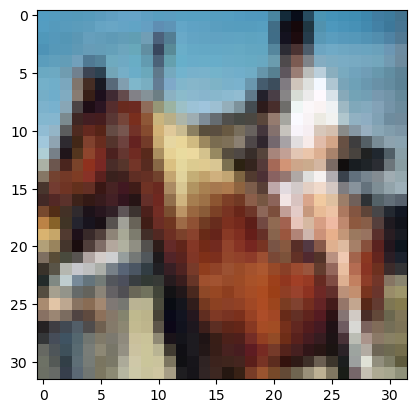

In [3]:
plt.imshow(x_train[0])
plt.show()

# 1. From the Sequential API to the Functional API

## 1.1 An initial CNN (the usual way)

Let's start by building and training a CNN from scratch, as we have seen many times before:

In [4]:
model = tf.keras.Sequential([
    Conv2D(filters=32, kernel_size=3, activation="relu", input_shape = input_shape),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=64, kernel_size=3, activation="relu"),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=128, kernel_size=3, activation="relu"),
    Flatten(),
    Dense(num_classes, activation="softmax")
])

2023-04-14 03:48:18.668165: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


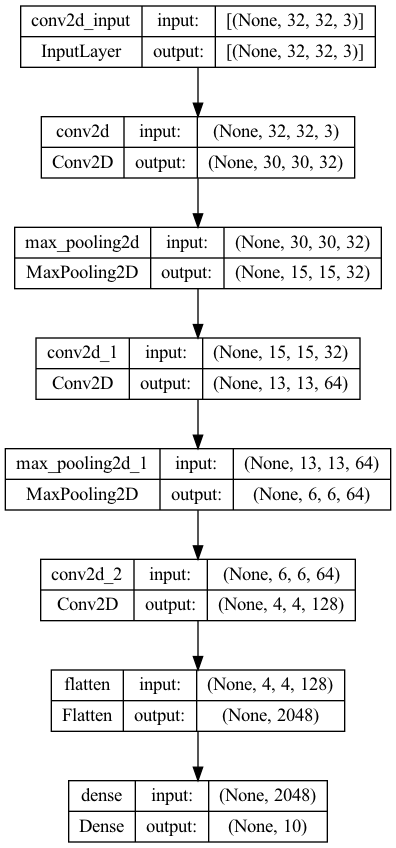

In [5]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [6]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=64,
          epochs=20,
          validation_split=0.2)

Epoch 1/20
13/13 [==============================] - 1s 29ms/step - loss: 2.3180 - accuracy: 0.1238 - val_loss: 2.2504 - val_accuracy: 0.1650
Epoch 2/20
13/13 [==============================] - 0s 18ms/step - loss: 2.2130 - accuracy: 0.1750 - val_loss: 2.1094 - val_accuracy: 0.1950
Epoch 3/20
13/13 [==============================] - 0s 17ms/step - loss: 2.1168 - accuracy: 0.2200 - val_loss: 2.0208 - val_accuracy: 0.2200
Epoch 4/20
13/13 [==============================] - 0s 17ms/step - loss: 2.0045 - accuracy: 0.2625 - val_loss: 1.9726 - val_accuracy: 0.2600
Epoch 5/20
13/13 [==============================] - 0s 17ms/step - loss: 1.9303 - accuracy: 0.2975 - val_loss: 1.9306 - val_accuracy: 0.2900
Epoch 6/20
13/13 [==============================] - 0s 17ms/step - loss: 1.8911 - accuracy: 0.3088 - val_loss: 1.8298 - val_accuracy: 0.3000
Epoch 7/20
13/13 [==============================] - 0s 17ms/step - loss: 1.7953 - accuracy: 0.3500 - val_loss: 2.0512 - val_accuracy: 0.2050
Epoch 8/20
13

## 1.2 The same, but different

We will now repeat the process. However, instead of using TensorFlow's Sequential API, we will now use the Functional API. What's the difference? Essentially, each layer is now defined independently of the others. We are connecting layers by using previous layers as their inputs. Because layers are independent, we have to specify a `tf.keras.Model` with all the inputs and outputs of our model.

Let's take a look, by creating the same model as before using the Functional API:

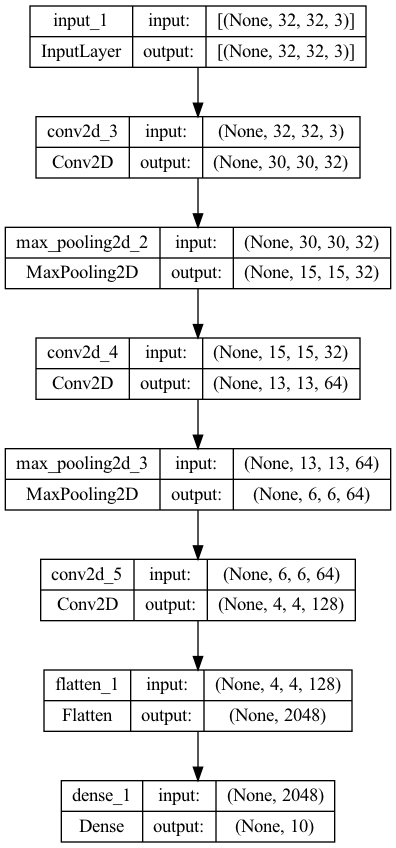

In [7]:
inputs = tf.keras.Input(shape=input_shape)
x = Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = Flatten()(x)
outputs = Dense(num_classes, activation="softmax")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

tf.keras.utils.plot_model(model, show_shapes=True)

We train this model in the same way as before:

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=64,
          epochs=20,
          validation_split=0.2)

Epoch 1/20
13/13 [==============================] - 1s 28ms/step - loss: 2.2930 - accuracy: 0.1050 - val_loss: 2.3098 - val_accuracy: 0.1050
Epoch 2/20
13/13 [==============================] - 0s 19ms/step - loss: 2.2183 - accuracy: 0.1912 - val_loss: 2.0974 - val_accuracy: 0.1950
Epoch 3/20
13/13 [==============================] - 0s 18ms/step - loss: 2.1069 - accuracy: 0.2125 - val_loss: 1.9291 - val_accuracy: 0.2900
Epoch 4/20
13/13 [==============================] - 0s 17ms/step - loss: 2.0347 - accuracy: 0.2663 - val_loss: 1.9939 - val_accuracy: 0.2000
Epoch 5/20
13/13 [==============================] - 0s 23ms/step - loss: 1.9046 - accuracy: 0.3000 - val_loss: 1.8952 - val_accuracy: 0.2700
Epoch 6/20
13/13 [==============================] - 0s 18ms/step - loss: 1.9013 - accuracy: 0.3262 - val_loss: 1.9281 - val_accuracy: 0.3050
Epoch 7/20
13/13 [==============================] - 0s 18ms/step - loss: 1.8122 - accuracy: 0.3288 - val_loss: 1.8203 - val_accuracy: 0.3100
Epoch 8/20
13

## 1.3 A simple non-sequential model

So far, there was no difference. The Functional API is more powerful, however. In particular, it allows us to train non-sequential models (that is, models that are not simply a stack of one layer after the other.

Here, we will train a model that predicts both the class of an images, as well as a random number (this doesn't have much meaning but it is really just to show you how we can use the Functional API of TensorFlow).

Let's first create the secondary y's:

In [9]:
train_means = np.mean(x_train,axis=(1,2,3))
y2_train = np.random.normal(train_means,np.abs(train_means/2))

test_means = np.mean(x_test,axis=(1,2,3))
y2_test = np.random.normal(test_means,np.abs(test_means/2))

Let's now build the model. Note, in particular, that we have two outputs, and each takes as their input the `Flatten` layer. When we create the model, we simply specify `outputs` using a list:

In [12]:
inputs = tf.keras.Input(shape=input_shape)
x = Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = Flatten()(x)
output1 = Dense(num_classes, activation="softmax", name = 'output_1')(x)
output2 = Dense(1, activation="sigmoid", name = 'output_2')(x)

model = tf.keras.Model(inputs=inputs, outputs=[output1,output2])

Plotting the model, we directly see the difference:

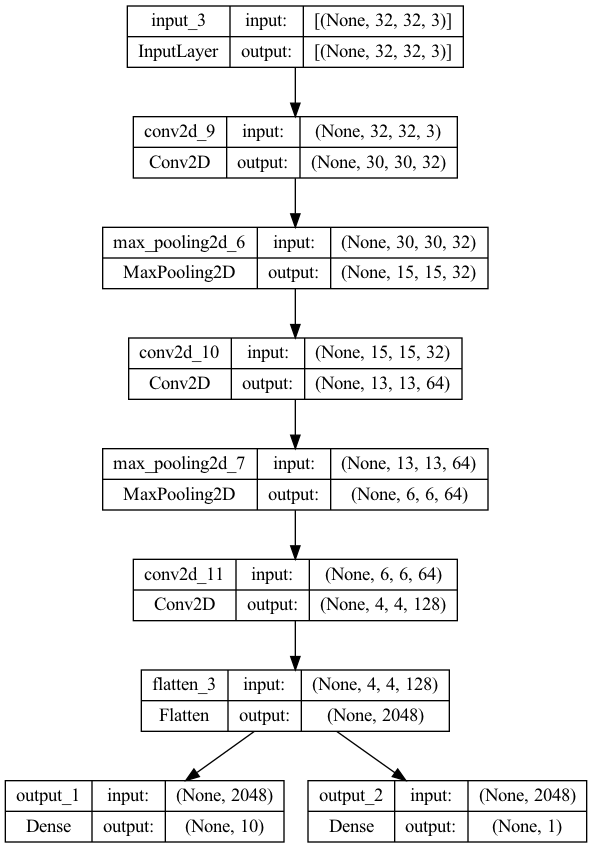

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True)

Let's now compile our non-sequential model. We need to define our losses and metrics for each of our outputs! This is why we gave the output layers specific names, so we can use this here. Alternatively, you could also specify these as a list, so you don't necessarily need to have a name for each.

Note that we also add `loss_weights`, to define how important each part of the outputs (or the loss on those) is when assessing the gradients.

In [14]:
model.compile(loss={'output_1':'binary_crossentropy',
                         'output_2':'mean_squared_error'},
               loss_weights = [1,0.01],
               metrics = {'output_1':'accuracy',
                         'output_2':'mean_squared_error'},
               optimizer='rmsprop')

We train the model as before. Because we have two outputs, we also have to have two y-variables. Again, we can simply use a list.

In [15]:
model.fit(x_train, y=[y_train,y2_train],
          batch_size=64,
          epochs=20,
          validation_split=0.2)

Epoch 1/20
13/13 [==============================] - 1s 31ms/step - loss: 0.3919 - output_1_loss: 0.3909 - output_2_loss: 0.0944 - output_1_accuracy: 0.1000 - output_2_mean_squared_error: 0.0944 - val_loss: 0.3380 - val_output_1_loss: 0.3370 - val_output_2_loss: 0.0947 - val_output_1_accuracy: 0.1200 - val_output_2_mean_squared_error: 0.0947
Epoch 2/20
13/13 [==============================] - 0s 19ms/step - loss: 0.3413 - output_1_loss: 0.3404 - output_2_loss: 0.0864 - output_1_accuracy: 0.1187 - output_2_mean_squared_error: 0.0864 - val_loss: 0.3483 - val_output_1_loss: 0.3474 - val_output_2_loss: 0.0883 - val_output_1_accuracy: 0.1150 - val_output_2_mean_squared_error: 0.0883
Epoch 3/20
13/13 [==============================] - 0s 19ms/step - loss: 0.3368 - output_1_loss: 0.3360 - output_2_loss: 0.0819 - output_1_accuracy: 0.1300 - output_2_mean_squared_error: 0.0819 - val_loss: 0.3411 - val_output_1_loss: 0.3401 - val_output_2_loss: 0.1038 - val_output_1_accuracy: 0.1250 - val_output_

Similarly, when we evaluate the model, we need to specify multiple y's:

In [16]:
model.evaluate(x_test, [y_test,y2_test])

32/32 [==============================] - 0s 4ms/step - loss: 0.2721 - output_1_loss: 0.2715 - output_2_loss: 0.0654 - output_1_accuracy: 0.3500 - output_2_mean_squared_error: 0.0654


[0.272122859954834,
 0.2714686393737793,
 0.06542101502418518,
 0.3499999940395355,
 0.06542101502418518]

And we can make predictions as before. We just have to note that two outputs are being predicted, the labels and the average values. But we can simply use list-indices to get the right ones.

In [17]:
predictions = model.predict(x_test)
print(predictions[0].shape)
print(predictions[1].shape)

32/32 [==============================] - 0s 4ms/step
(1000, 10)
(1000, 1)


**Discussion**:
- What key differences do you observe between the Sequential API and the Functional API?
- For which types of applications is the Sequential API insufficient?

## 1.4 A typical application for non-sequential models

Non-sequential often come in handy and most people really use the Functional API as the default due to its greater flexibility. One application area is object detection.

**Discussion**: Why do we need multiple outputs when doing object detection?

While building an object detction model from scratch is very time-consuming, let's take a look at a pre-built one. In particular, we will use this step to introduce the TensorFlow Hub, where you can download a large range of models. You might have to first install the corresponding package. On the website of the [TensorFlow Hub](https://tfhub.dev/) you can find models based on the application you are interested in. Take a look, for example, at [models for object detection](https://tfhub.dev/s?module-type=image-object-detection).

In [20]:
pip install tensorflow_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.6/100.6 kB 1.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [21]:
import tensorflow_hub as hub

We will load a pre-trained model "Efficient Det". Note that this is not a Keras model, but a pure TensorFlow model, so we cannot do things like displaying a summary (but we can use the model to run predictions). Don't worry about the long loading time and the warnings!

In [22]:
hub_model = hub.load('https://tfhub.dev/tensorflow/efficientdet/d0/1')

Our model takes images and creates classifications for different objects within the images (together with bounding boxes). Each class has a number, so we need to be able to go from that number to the actual class name. The following pieces of code load the '.pbtxt' file necessary for this transformation, and creates a dictionary mapping class numbers to names:

In [23]:
def read_label_map(label_map_path):
    item_id = None
    item_name = None
    items = {}
    with open(label_map_path, "r") as file:
        for line in file:
            line.replace(" ", "")
            if line == "item{":
                pass
            elif line == "}":
                pass
            elif "id" in line:
                item_id = int(line.split(":", 1)[1].strip())
            elif "display_name" in line:
                item_name = line.split(":", 1)[1].replace('"', '').strip()

            if item_id is not None and item_name is not None:
                items[item_id] = item_name
                item_id = None
                item_name = None

    return items

In [24]:
r = requests.get("https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt")
f = open("mscoco_label_map.pbtxt",'wb')
f.write(r.content)

5056

In [25]:
class_names = read_label_map("mscoco_label_map.pbtxt")

If you explore `class_names`, you will get an idea of the kind of categories our model can detect:

In [26]:
class_names

{1: 'person',
 2: 'bicycle',
 3: 'car',
 4: 'motorcycle',
 5: 'airplane',
 6: 'bus',
 7: 'train',
 8: 'truck',
 9: 'boat',
 10: 'traffic light',
 11: 'fire hydrant',
 13: 'stop sign',
 14: 'parking meter',
 15: 'bench',
 16: 'bird',
 17: 'cat',
 18: 'dog',
 19: 'horse',
 20: 'sheep',
 21: 'cow',
 22: 'elephant',
 23: 'bear',
 24: 'zebra',
 25: 'giraffe',
 27: 'backpack',
 28: 'umbrella',
 31: 'handbag',
 32: 'tie',
 33: 'suitcase',
 34: 'frisbee',
 35: 'skis',
 36: 'snowboard',
 37: 'sports ball',
 38: 'kite',
 39: 'baseball bat',
 40: 'baseball glove',
 41: 'skateboard',
 42: 'surfboard',
 43: 'tennis racket',
 44: 'bottle',
 46: 'wine glass',
 47: 'cup',
 48: 'fork',
 49: 'knife',
 50: 'spoon',
 51: 'bowl',
 52: 'banana',
 53: 'apple',
 54: 'sandwich',
 55: 'orange',
 56: 'broccoli',
 57: 'carrot',
 58: 'hot dog',
 59: 'pizza',
 60: 'donut',
 61: 'cake',
 62: 'chair',
 63: 'couch',
 64: 'potted plant',
 65: 'bed',
 67: 'dining table',
 70: 'toilet',
 72: 'tv',
 73: 'laptop',
 74: 'mo

We now load and display an example image, which we will run through our model:

(-0.5, 2999.5, 1999.5, -0.5)

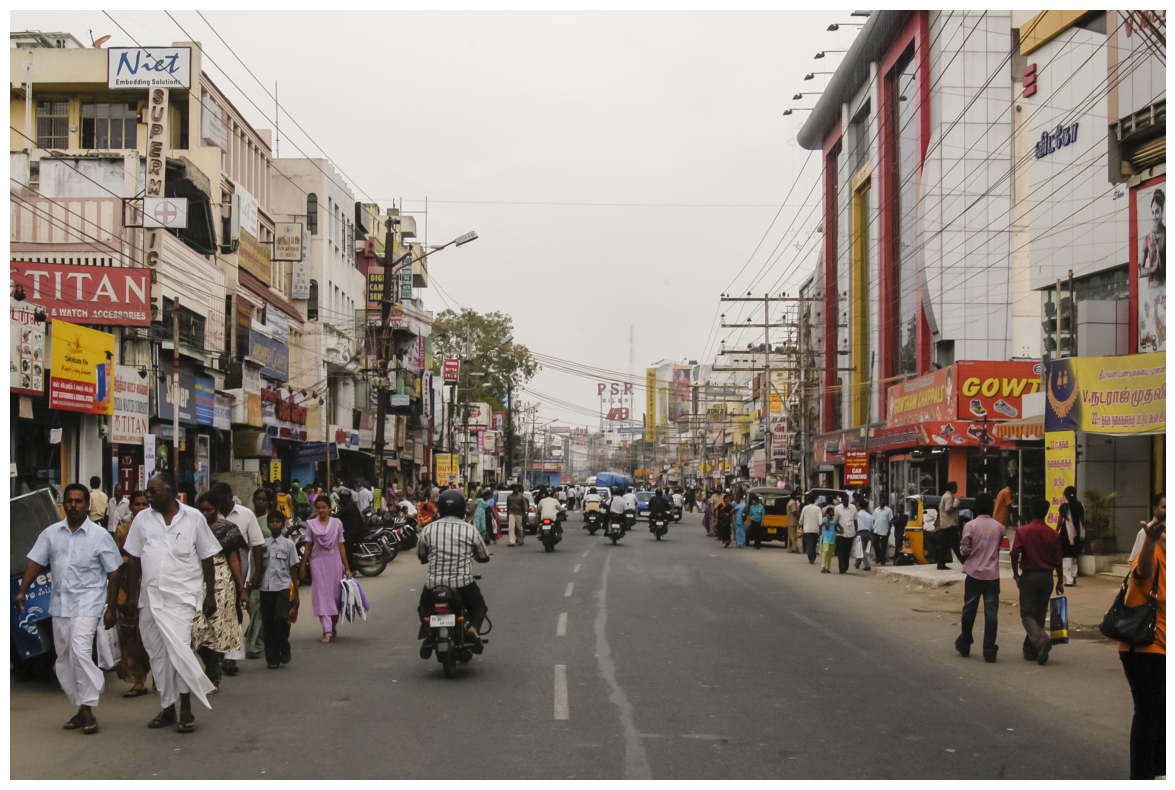

In [27]:
url = "https://upload.wikimedia.org/wikipedia/commons/1/1f/A_street_scene_in_Coimbatore%2C_Tamil_Nadu%2C_India.jpg"
url_response = urllib.request.urlopen(url)
img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
img = cv2.imdecode(img_array, -1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w, _ = img.shape
plt.figure(figsize=(16,10))
plt.imshow(img)
plt.axis('off')

We now apply our model to that image:

In [28]:
input_tensor = np.expand_dims(img, 0)
res = hub_model(input_tensor)
print(len(res))

8


There are 8 different outputs from our object detection model. Luckily, the outputs are in a dictionary with quite interpretable names. Take a look.

**Discussion**: can you interpret what types of outputs we have here?

In [29]:
res.keys()

dict_keys(['raw_detection_boxes', 'detection_anchor_indices', 'detection_classes', 'detection_scores', 'raw_detection_scores', 'detection_boxes', 'detection_multiclass_scores', 'num_detections'])

We can now display our bounding boxes and classifications on top of the image. We are not displaying all bounding boxes, but only those for which our model is relatively certain.

(-0.5, 2999.5, 1999.5, -0.5)

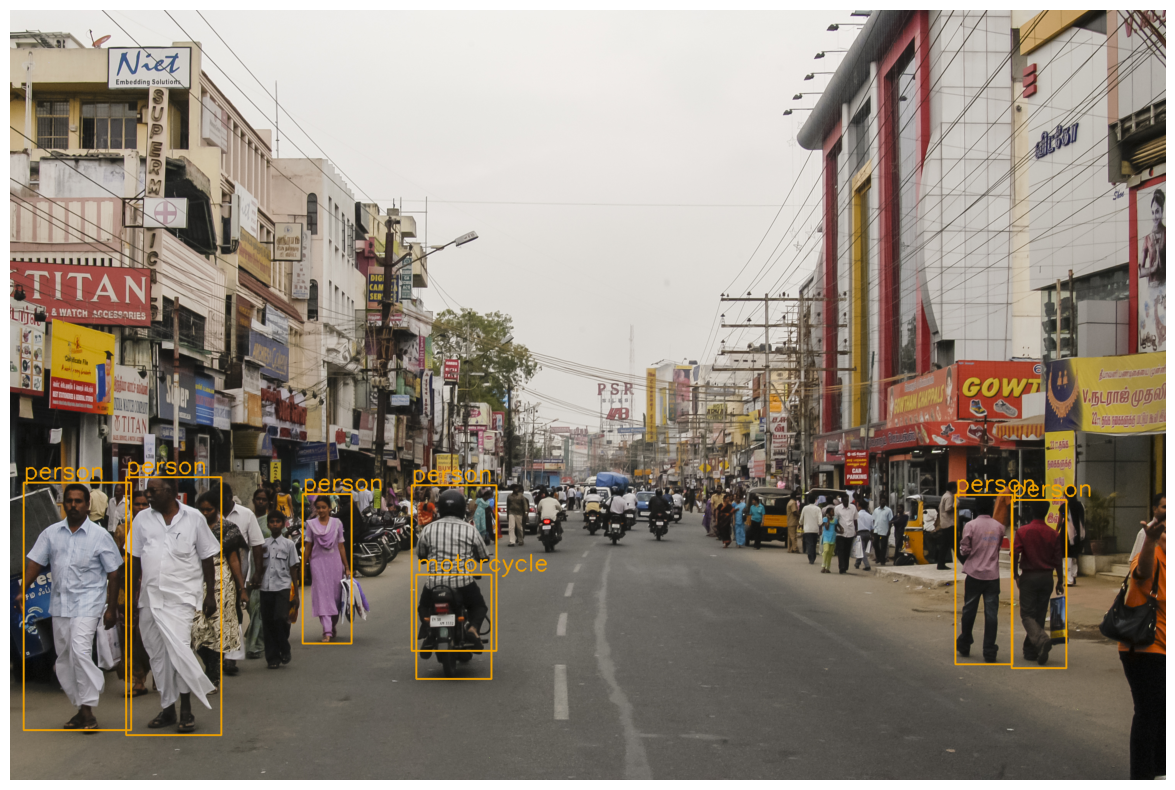

In [30]:
img = cv2.imdecode(img_array, -1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for boxes, classes, scores in zip(res['detection_boxes'].numpy(), res['detection_classes'], res['detection_scores'].numpy()):
    for box, cls, score in zip(boxes, classes, scores): # iterate over sub values in list
        if score > 0.5: # our confidence threshold for displaying boxes
            ymin = int(box[0] * h)
            xmin = int(box[1] * w)
            ymax = int(box[2] * h)
            xmax = int(box[3] * w)
            # write classname for bounding box
            cv2.putText(img, class_names[tf.cast(cls,dtype=tf.uint8).numpy()], (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (238, 160, 0), 4)
            # draw on image
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (238, 160, 0), 4)

plt.figure(figsize=(16,10))
plt.imshow(img)
plt.axis('off')

**Discussion**:  Changing the confidence threshold, what do you observe?

# 2. Some practical issues specific to CNNs

## 2.1 Residual connections

The general idea is that we add the input of a block to the output, in order to avoid loss of information. This is accomplished with `tf.keras.layers.add([x,residual])`. However, there is a problem, as you will discover when running the below:

In [31]:
inputs = tf.keras.Input(shape=input_shape)

x = Conv2D(32, 3, activation="relu")(inputs)
residual = inputs

x = tf.keras.layers.add([x, residual])

ValueError: Inputs have incompatible shapes. Received shapes (30, 30, 32) and (32, 32, 3)

We have to ensure that our residual has the same dimensions. In this case, we need more channels and we also need to make sure that our block doens't reduce the size. Take a look at the following piece of code.

**Discussion**: In the next code block, can you spot how we avoid the previous issues?

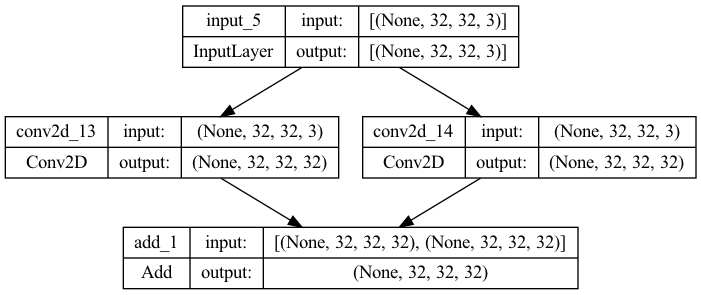

In [32]:
inputs = tf.keras.Input(shape=input_shape)

x = Conv2D(32, 3, activation="relu", padding="same")(inputs)
residual = inputs
residual = Conv2D(32, 1)(residual)

x = tf.keras.layers.add([x, residual])
model = tf.keras.Model(inputs=inputs, outputs=x)
tf.keras.utils.plot_model(model, show_shapes=True)

Let's scale this up. We want to create a number of neural network with three blocks, as before (32 filters, 64 filters, 128 filters). However, each block also contains a `MaxPooling` layer, while the residual is used to connect the input to the block to the output. As in the original example, however, we avoid the `MaxPooling` layer at the last block.

**Discussion**: Why do we need apply `strides=2` for the convolution of the residual?

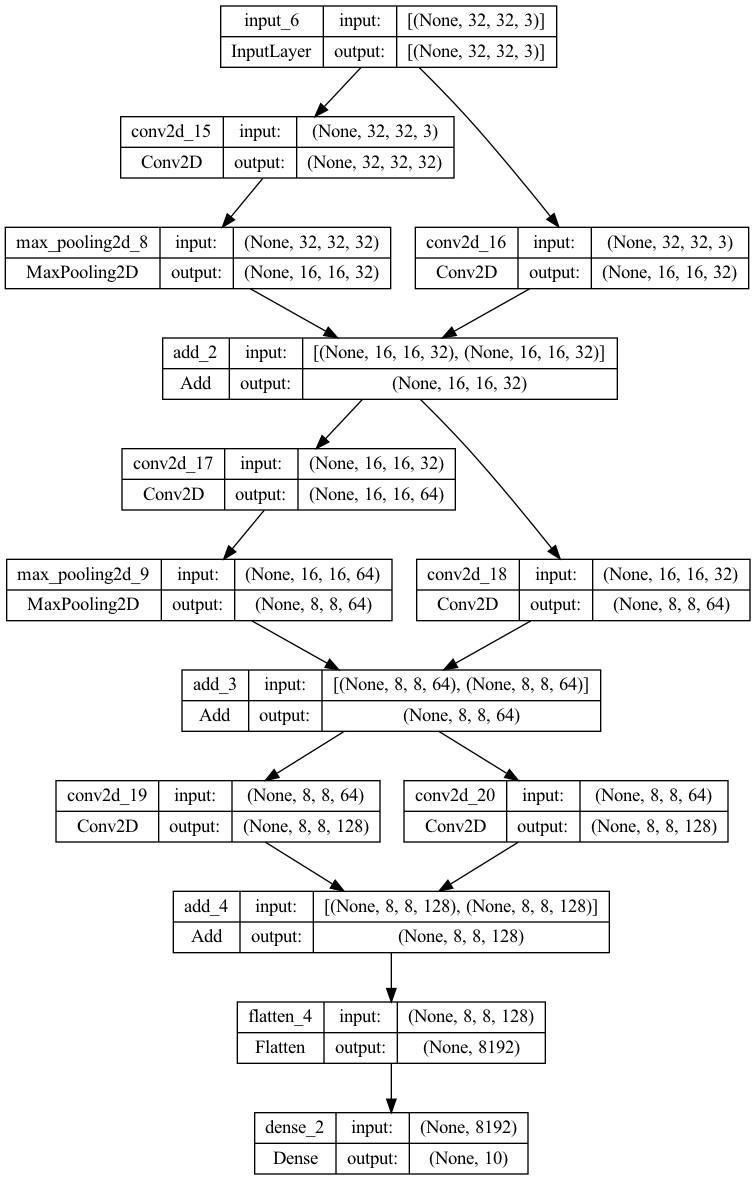

In [33]:
inputs = tf.keras.Input(shape=input_shape)
x = inputs

def residual_block(x, filters,pooling=False):
    residual = x
    x = Conv2D(filters, 3, activation="relu", padding="same")(x)
    if pooling:
        x = MaxPooling2D(2, padding="same")(x)
        residual = Conv2D(filters, 1, strides=2)(residual) 
    else:
        residual = Conv2D(filters, 1)(residual)
    x = tf.keras.layers.add([x, residual])
    return x

x = residual_block(x, filters=32,pooling=True)
x = residual_block(x, filters=64,pooling=True)
x = residual_block(x, filters=128,pooling=False)

x = Flatten()(x)
outputs = Dense(num_classes, activation="softmax")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
tf.keras.utils.plot_model(model, show_shapes=True)

In [34]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=64,
          epochs=20,
          validation_split=0.2)

Epoch 1/20
13/13 [==============================] - 1s 54ms/step - loss: 2.9276 - accuracy: 0.1425 - val_loss: 2.1131 - val_accuracy: 0.1650
Epoch 2/20
13/13 [==============================] - 1s 42ms/step - loss: 2.0668 - accuracy: 0.2725 - val_loss: 2.0417 - val_accuracy: 0.2200
Epoch 3/20
13/13 [==============================] - 0s 35ms/step - loss: 1.9279 - accuracy: 0.3575 - val_loss: 2.5696 - val_accuracy: 0.1600
Epoch 4/20
13/13 [==============================] - 0s 34ms/step - loss: 1.7244 - accuracy: 0.4250 - val_loss: 1.9257 - val_accuracy: 0.2300
Epoch 5/20
13/13 [==============================] - 0s 37ms/step - loss: 1.5755 - accuracy: 0.4550 - val_loss: 1.8379 - val_accuracy: 0.3500
Epoch 6/20
13/13 [==============================] - 0s 33ms/step - loss: 1.3950 - accuracy: 0.5312 - val_loss: 1.8475 - val_accuracy: 0.3350
Epoch 7/20
13/13 [==============================] - 0s 33ms/step - loss: 1.2780 - accuracy: 0.5713 - val_loss: 1.9820 - val_accuracy: 0.3000
Epoch 8/20
13

## 2.2 Data augmentation

We have seen Data augmentation before, using the ImageDataGenerator. Starting with TensorFlow version 2.2, there are also layers that can be added into the network that essentially do the same thing. They have one key advantage: the augmentation process happens on the GPU rather than the CPU.

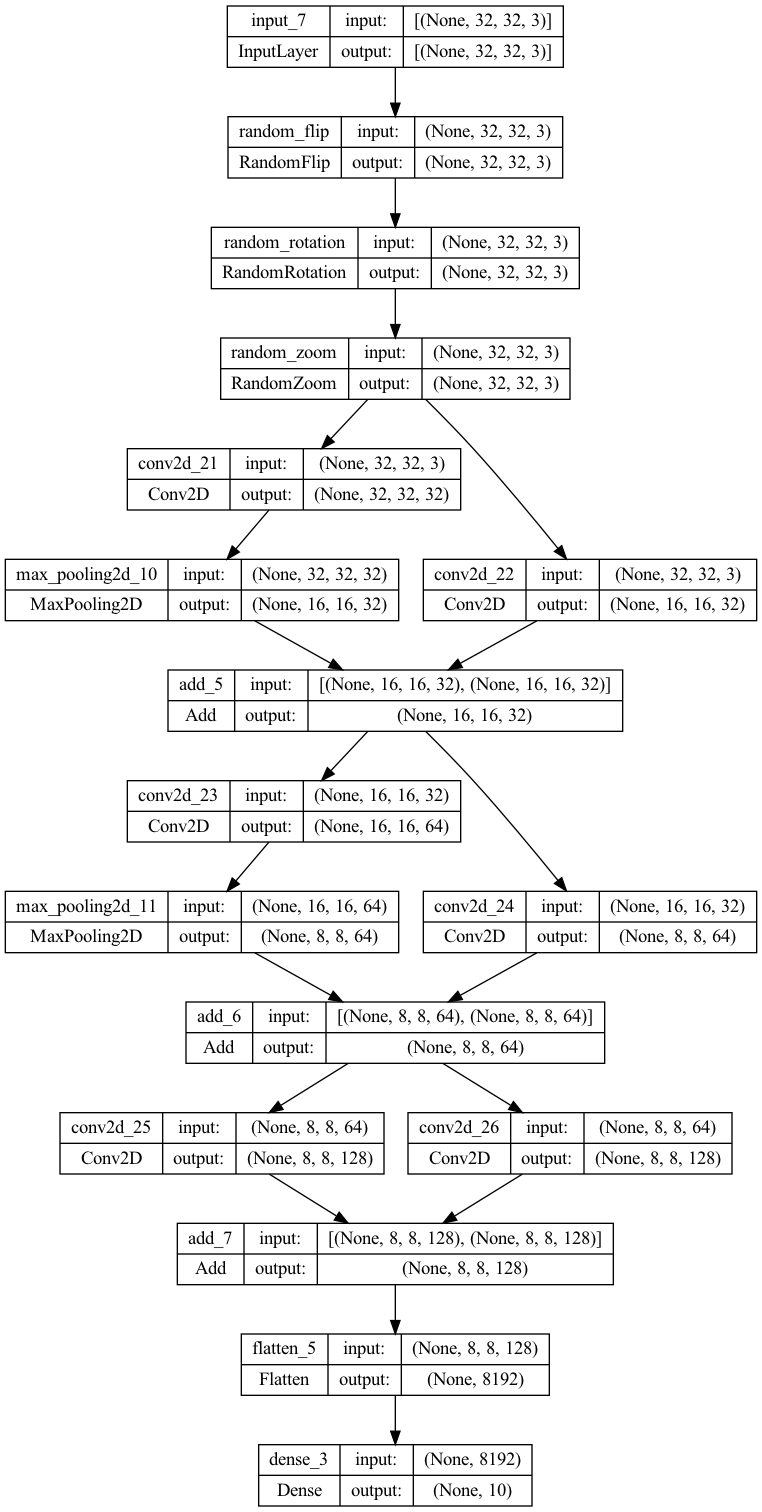

In [35]:
inputs = tf.keras.Input(shape=input_shape)

x = tf.keras.layers.RandomFlip("horizontal") (inputs)
x = tf.keras.layers.RandomRotation(0.1)(x)
x = tf.keras.layers.RandomZoom(0.2)(x)

x = residual_block(x, filters=32,pooling=True)
x = residual_block(x, filters=64,pooling=True)
x = residual_block(x, filters=128,pooling=False)

x = Flatten()(x)
outputs = Dense(num_classes, activation="softmax")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
tf.keras.utils.plot_model(model, show_shapes=True)

In [36]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=64,
          epochs=20,
          validation_split=0.2)

Epoch 1/20
13/13 [==============================] - 2s 48ms/step - loss: 2.5948 - accuracy: 0.1488 - val_loss: 2.0832 - val_accuracy: 0.2450
Epoch 2/20
13/13 [==============================] - 0s 35ms/step - loss: 2.1137 - accuracy: 0.2512 - val_loss: 1.9587 - val_accuracy: 0.3000
Epoch 3/20
13/13 [==============================] - 0s 38ms/step - loss: 2.0150 - accuracy: 0.2775 - val_loss: 1.8037 - val_accuracy: 0.3300
Epoch 4/20
13/13 [==============================] - 0s 37ms/step - loss: 1.9229 - accuracy: 0.3100 - val_loss: 1.8751 - val_accuracy: 0.3550
Epoch 5/20
13/13 [==============================] - 0s 37ms/step - loss: 1.8688 - accuracy: 0.3500 - val_loss: 1.9034 - val_accuracy: 0.2850
Epoch 6/20
13/13 [==============================] - 0s 37ms/step - loss: 1.7446 - accuracy: 0.3825 - val_loss: 1.8042 - val_accuracy: 0.3550
Epoch 7/20
13/13 [==============================] - 0s 37ms/step - loss: 1.6761 - accuracy: 0.4112 - val_loss: 1.8015 - val_accuracy: 0.3550
Epoch 8/20
13

## 2.3 Depthwise separable convolutions and putting everything together

We combine some of the architectural principles that we learned about to build a simplified version of the [Xception](https://openaccess.thecvf.com/content_cvpr_2017/papers/Chollet_Xception_Deep_Learning_CVPR_2017_paper.pdf) model.

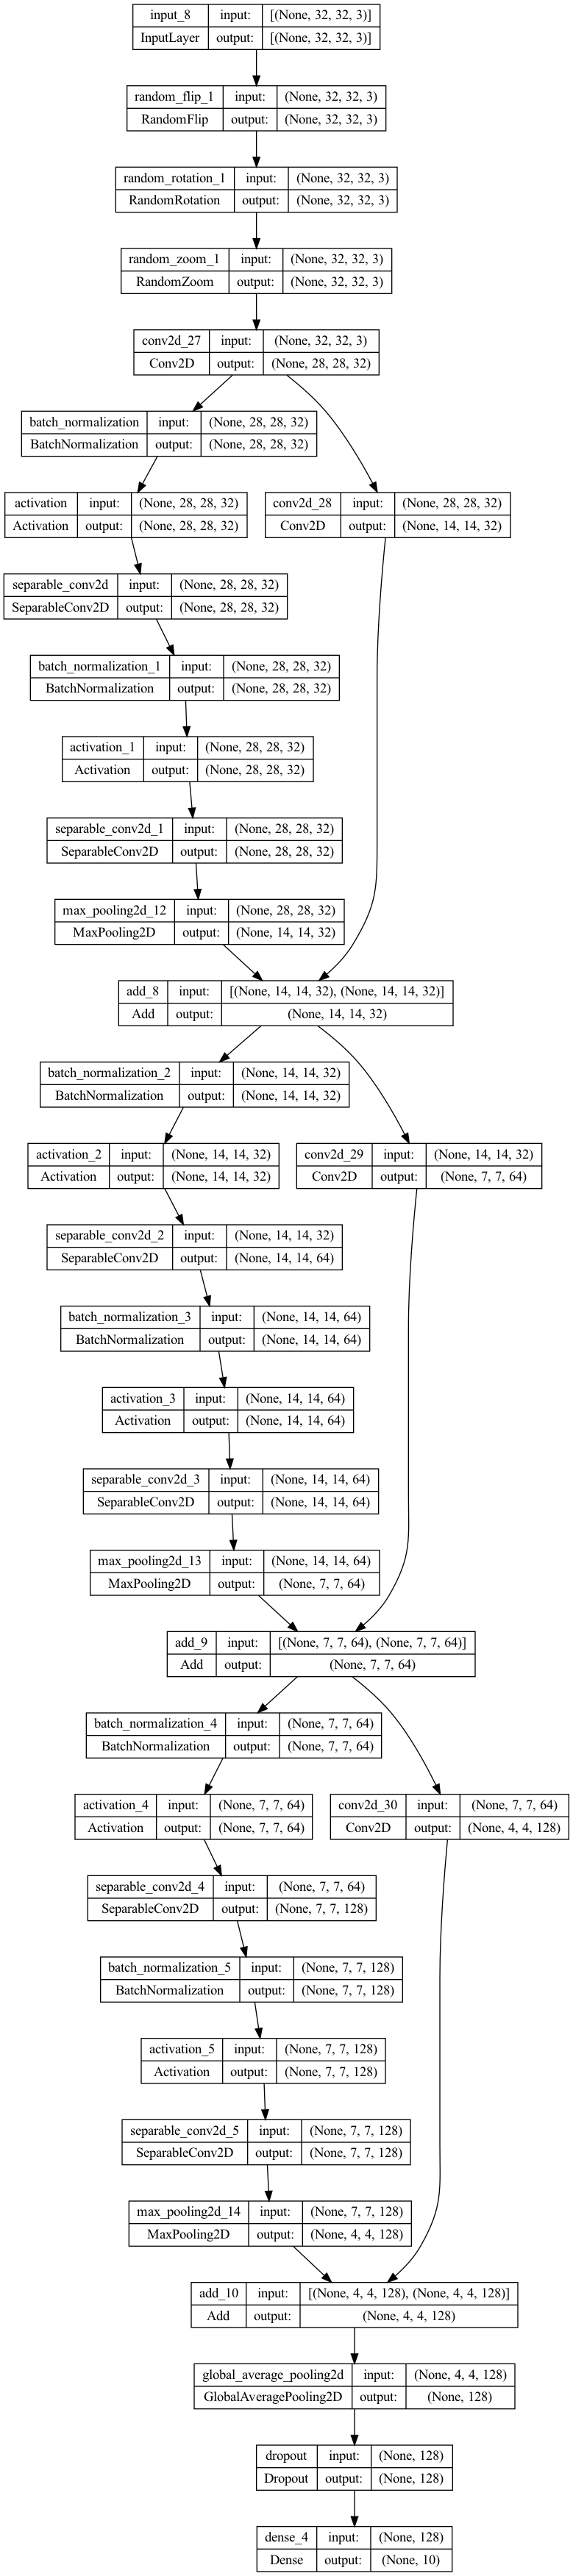

In [37]:
inputs = tf.keras.Input(shape=input_shape)

x = tf.keras.layers.RandomFlip("horizontal")(inputs)
x = tf.keras.layers.RandomRotation(0.1)(x)
x = tf.keras.layers.RandomZoom(0.2)(x)

x = Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128]:
    residual = x

    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = MaxPooling2D(3, strides=2, padding="same")(x)

    residual = Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = tf.keras.layers.add([x, residual])

x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation="softmax")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
tf.keras.utils.plot_model(model, show_shapes=True)

Note that this is quite the big model for the amount of data we have, so we need to put in a lot more work to train. The below code will get you only so far. For better performance, you will want to fine-tune the learning rate and batch size and add a learning rate schedule (and increase the number of epochs)

In [38]:
model.compile(loss='categorical_crossentropy',
              optimizer="rmsprop",
              metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=32,
          epochs=40,
          validation_split=0.2)

Epoch 1/40
25/25 [==============================] - 3s 41ms/step - loss: 2.2823 - accuracy: 0.1538 - val_loss: 2.3614 - val_accuracy: 0.1300
Epoch 2/40
25/25 [==============================] - 1s 34ms/step - loss: 2.1118 - accuracy: 0.2150 - val_loss: 2.3573 - val_accuracy: 0.0750
Epoch 3/40
25/25 [==============================] - 1s 34ms/step - loss: 2.0185 - accuracy: 0.2488 - val_loss: 2.4167 - val_accuracy: 0.0750
Epoch 4/40
25/25 [==============================] - 1s 31ms/step - loss: 1.9595 - accuracy: 0.2750 - val_loss: 2.4372 - val_accuracy: 0.0750
Epoch 5/40
25/25 [==============================] - 1s 32ms/step - loss: 1.8888 - accuracy: 0.2675 - val_loss: 2.4223 - val_accuracy: 0.0800
Epoch 6/40
25/25 [==============================] - 1s 33ms/step - loss: 1.8520 - accuracy: 0.2912 - val_loss: 2.6082 - val_accuracy: 0.0800
Epoch 7/40
25/25 [==============================] - 1s 32ms/step - loss: 1.7763 - accuracy: 0.3413 - val_loss: 2.5575 - val_accuracy: 0.0750
Epoch 8/40
25

**Discussion**: can you fine-tune the process in order to get a better-performing model?

# 3. Transfer learning to use pre-trained models

We will now use a pre-trained Xception network instead of trying to train one from scratch. There are multiple ways to do so. The first will rely on using only the outputs from the network and training our own classifier based on those:

## 3.1 Using pre-trained model outputs as inputs to our model

In order to run the Xception network that comes directly with TensorFlow, we need to adjust our data. Luckily most of the hard lifting is done by the `preprocess_input` function that comes with it.

In [ ]:
from tensorflow.keras.applications.xception import Xception, preprocess_input

Note that the function takes numpy arrays with pixel values from 0-255. As we had normalized earlier, we need to rescale first.

In [ ]:
x_preprocess_train = preprocess_input(x_train.copy()*255)
x_preprocess_test = preprocess_input(x_test.copy()*255)
print(x_preprocess_train.shape)
print(x_preprocess_test.shape)

As you can find in the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications/xception/Xception), we need to have images with that are at least 71x71. Say you have smaller images (in our case 32x32) and we want to make them bigger. There are different ways to do this. One way is to use the `zoom` from `scipy`. This adds in new pixels whose value is based on spline interpolation. Run the following code, which might take a few minutes.

In [ ]:
from scipy.ndimage import zoom

print('Processing training data')
resized_images = []
for i in range(x_preprocess_train.shape[0]):
    resized_images.append(zoom(x_preprocess_train[i], (5.0, 5.0, 1.0)))
    if (i+1) % 200 == 0:
        print('* Processed %d images' % (i+1))
x_preprocess_train = np.stack(resized_images)

print('Processing testing data')
resized_images = []
for i in range(x_preprocess_test.shape[0]):
    resized_images.append(zoom(x_preprocess_test[i], (5.0, 5.0, 1.0)))
    if (i+1) % 200 == 0:
        print('* Processed %d images' % (i+1))
x_preprocess_test = np.stack(resized_images)

print(x_preprocess_train.shape)
print(x_preprocess_test.shape)

Let's plot again our sample image (which needs to be reshaped appropriately again): You will see that the resolution is much better, because we now have more pixels. How did we decide to fill those pixels up? By interpolating between the values of the pixels around.

Let's plot again our sample image (which needs to be reshaped appropriately again): You will see that the resolution is much better, because we now have more pixels. How did we decide to fill those pixels up? By interpolating between the values of the pixels around.

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(x_preprocess_train[0] + 0.5)
plt.show()

We are now ready to build a model. Our basis will be the Xception network, with the parameters trained on ImageNet.  Notice we add the `include_top=False` parameter because we don't want to use the included ImageNet classifier.

In [ ]:
xception = Xception(weights='imagenet', include_top=False, input_shape = (160,160,3))
xception.summary()

Xception outputs a (5, 5, 2048) tensor before it's "top layer" (which we didn't download).  We compute the relevant activation of this top layer for our images (this represents a range of high-level features of our images). We then aggregate the top layer activation using a `GlobalAveragePooling2D` layer, which compresses it into a (1, 1, 2048) tensor, which we can easily turn into a 2048-vector.  `GlobalAveragePooling2D` works by taking the average of each 5x5 feature map.

Let's extract high-level features of our images using Xception (this may take a few minutes)

In [ ]:
x_features_train = xception.predict(x_preprocess_train)
x_features_test = xception.predict(x_preprocess_test)
print(x_features_train.shape)
print(x_features_test.shape)

Let's now build a simple feed-forward network which uses these features as an input, to predict the right classes:

In [ ]:
model = tf.keras.Sequential([
    GlobalAveragePooling2D(input_shape=(5,5,2048)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')])
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.fit(x_features_train, y_train,
          batch_size=64,
          epochs=20,
          validation_split=0.2)

**Discussion**:
1. What happens if you don't use the `GlobalAveragePooling2D` layer (note: you will need a `Flatten` layer instead)?  Hypothesize why the performance changes.
1. Why does the image need to be preprocessed via the `preprocess_input()` function?  Hypothesize what happens if we omit this step.
1. Why do we need to resize the image (via `zoom`)?

## 3.2 Using Frozen Layers

Instead of using pre-processed features, we add the pre-trained MobileNet network to our model (and freeze it, to avoid changing its weights). This allows us to do things like data augmentation, or to process our data on the go. We start from the (non-processed data)>

In [ ]:
x_preprocess_train = preprocess_input(x_train.copy()*255)
x_preprocess_test = preprocess_input(x_test.copy()*255)

We integrate the `Xception` layers into our network. But before that, we need to resize the images. This time, we use "upsampling". Basically, we add additional pixels that are copies of the existing ones, i.e., we "stretch out" the pixels.

We will conduct upsampling directly in our neural network, so there is not need to do additional pre-processing. After the upsampling, we also do some data augmentation, as before.

In [ ]:
xception = Xception(weights='imagenet', include_top=False, input_shape = (160,160,3))
xception.trainable = False # This is key! We don't want to change the weights of the pre-trained model (for now)

model = tf.keras.Sequential([
    UpSampling2D(size=(5,5), input_shape = input_shape),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2),
    xception,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')])
    
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.fit(x_preprocess_train, y_train,
          batch_size=64,
          epochs=20,
          validation_split=0.2)

**Discussion**:

1. Why does the network train so much more slowly?
1. What is the difference (if any) between this model and the previous one?
1. How would you modify the above code if we wanted to train some of the Xception layers, but not all? Hint: you can iterate through the layers of a model with
```
for layer in model.layers:
```

# 4. Hot-Dog or Not-Dog: apply what you learned

This problem's purpose is to build a neural network to classify images as hot dogs or not-hot dogs. This is the same problem as seen in the HBO TV show "Silicon Valley". We will be using the dataset put together by [a user on Kaggle](https://www.kaggle.com/dansbecker/hot-dog-not-hot-dog) which contains 498 training images and 500 test images.

A simple CNN is given below. Due to the small sample size it has a very poor test set accuracy. Your task is to build a CNN that can beat this test set accuracy by a large margin (get to at least 70% test set accuracy).

First, we need a few more packages. If you don't currently have skimage or cv2 installed, uncomment and run the lines below:

In [ ]:
#pip install scikit-image
#pip install opencv-python

In [ ]:
from PIL import Image
import os, sys
import cv2
import tarfile
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator

We start by loading the data:

In [ ]:
path_to_data =  tf.keras.utils.get_file('hotdog.tar', 'https://www.dropbox.com/s/9zx61bhlrjx135j/hotdog.tar?dl=1')
file = tarfile.open(path_to_data)
file.extractall(os.path.abspath(os.path.join(path_to_data, os.pardir)))
file.close()

Let's take a look at two examples pictures:

In [ ]:
img_size = 160

img_arr_hotdog = cv2.imread(os.path.abspath(os.path.join(path_to_data, os.pardir,'hotdog/train/hot_dog/2417.jpg')))
img_arr_hotdog = cv2.resize(img_arr_hotdog, (img_size,img_size))[:,:,::-1]

img_arr_notdog = cv2.imread(os.path.abspath(os.path.join(path_to_data, os.pardir,'hotdog/train/not_hot_dog/197.jpg')))
img_arr_notdog = cv2.resize(img_arr_notdog, (img_size,img_size))[:,:,::-1]

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(img_arr_hotdog)
plt.title("Hot dog"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(img_arr_notdog)
plt.title("Not dog"); plt.grid(False)

Instead of loading all the data in advance, we create a data pipeline using an `ImageDataGenerator`. The generator will load in the data files as needed and perform two transformations:
- Rescaling pixels to be between [0, 1]
- Resizing images to be in `img_size`x`img_size` (160x160)

During training for each batch, the images are read from disk on the fly, loaded into memory and then the transformations are applied. Hence, we save on memory, which is one advantage of using the `ImageDataGenerator` instead of the specific augmentation layers (even though there are ways to also load from disk directly, but this goes beyond the scope here).

In [ ]:
train_data_dir = os.path.abspath(os.path.join(path_to_data, os.pardir,'hotdog/train'))
test_data_dir = os.path.abspath(os.path.join(path_to_data, os.pardir,'hotdog/test'))
batch_size = 128

train_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Data parameters (DO NOT MODIFY)
num_train_samples = 498
num_test_samples = 500

# Data generators (DO NOT MODIFY)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

### Defining and running an initial model

We define a starting model, which you will need to improve upon.

In [ ]:
model1 = tf.keras.Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(img_size,img_size,3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model1.summary()

When training the model, there is a small detail to consider: since we generate data on the fly, the training process doesn't know the total number of data points. Normally, in each epoch, we would take as many steps as needed to get through the whole dataset, given our batch_size. Hence, we have "training samples" / "batch size" as the number of steps per epoch. Here, we have to manually define that number of steps instead (and we do it in exactly this way, for consistency of the meaning of "epoch").

In [ ]:
model1.compile(loss='binary_crossentropy',
              metrics=['accuracy'], 
              optimizer='rmsprop')
model1.fit(train_generator,
            steps_per_epoch=num_train_samples // batch_size,
            epochs=20)

As usual, we evaluate the model. Again, the use of a generator implies only a small change.

In [ ]:
test_score = model1.evaluate(test_generator,steps=num_test_samples // batch_size, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

### Questions

1. Can you improve the model using Transfer Learning? You could use the MobileNet as before, or some completely different pre-trained model, such as one of the different [ResNet](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet) implementations in TensorFlow.
2. Are there other things you can do to improve the model?

### Example answer, part 1

Using transfer learning as the training dataset is relatively small for the application (here: `MobileNet`)

Since hotdog images probably have the same low-level details as that of the `ImageNet` dataset, such transfer learning should be feasible.

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet

In [ ]:
mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape = (160,160,3))
mobilenet.trainable = False

Note that mobilenet expects images to be scaled in the interval $[-1,1]$ [(see the documentation here)](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet/preprocess_input). Hence, we modify our `ImageDataGenerator` somewhat:

In [ ]:
train_datagen = ImageDataGenerator(rescale=2. / 255 - 1)
test_datagen = ImageDataGenerator(rescale=2. / 255 - 1)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

In [ ]:
model = tf.keras.Sequential([
    mobilenet,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

In [ ]:
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'], 
              optimizer="rmsprop")
model.fit(train_generator,
            steps_per_epoch=num_train_samples // batch_size,
            epochs=20)

In [ ]:
test_score = model.evaluate(test_generator,steps=num_test_samples // batch_size, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

Compared to the original model, which contains 1.2 million parameters to train on 498 images, the transfer learning model contains 3.2 million parameters, but only 65.7 thousand are trainable. As a result, the performance improves significantly (even though there is quite a bit of overfitting happening, which we may want to address in a second step).

### Example answer, part 2

We can try to unfreeze some layers close to the top of pre-trained `MobileNet`, to adapt the representation more closely to our hotdog/notdog images. In particular, we only freeze the layers up to the last, and keep the last one unfrozen: (note - always avoid unfreezing `BatchNormalization` layers)

In [ ]:
mobilenet.trainable = True
# Freeze layers in the base model except the last one
for layer in mobilenet.layers[:-1]:
    layer.trainable = False

The model can be defined as before. Notice how we now have around 2,000 more parameters that are trainable.

In [ ]:
model = tf.keras.Sequential([
    mobilenet,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary(expand_nested=True)

In [ ]:
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'], 
              optimizer="rmsprop")
model.fit(train_generator,
            steps_per_epoch=num_train_samples // batch_size,
            epochs=20)

In [ ]:
test_score = model.evaluate(test_generator,steps=num_test_samples // batch_size, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

By unfreezing layers close to the top, more parameters have become trainable. This can be helpful in training, but we don't see a vast improvement in this case (if any)